In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pytorch_eo.datasets.land_cover_net import LandCoverNet

ds = LandCoverNet(path="./data/LandCoverNet", batch_size=9)

ds.setup()

training samples 98410
validation samples 24603
test samples 30754


In [5]:
ds.classes

['water',
 'natural bare ground',
 'artificial bare ground',
 'woody vegetation',
 'cultivated vegetation',
 '(semi) natural vegetation',
 'permanent snow/ice']

In [6]:
ds.train_ds.images[:3]

['data/LandCoverNet/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33KXV_19_20181213',
 'data/LandCoverNet/ref_landcovernet_v1_source/ref_landcovernet_v1_source_31PGR_15_20180401',
 'data/LandCoverNet/ref_landcovernet_v1_source/ref_landcovernet_v1_source_34JHS_16_20180222']

In [7]:
imgs, masks = next(iter(ds.train_dataloader()))

imgs.shape, masks.shape, imgs.dtype, imgs.max(), imgs.min()

(torch.Size([9, 3, 256, 256]),
 torch.Size([9, 7, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.0375))

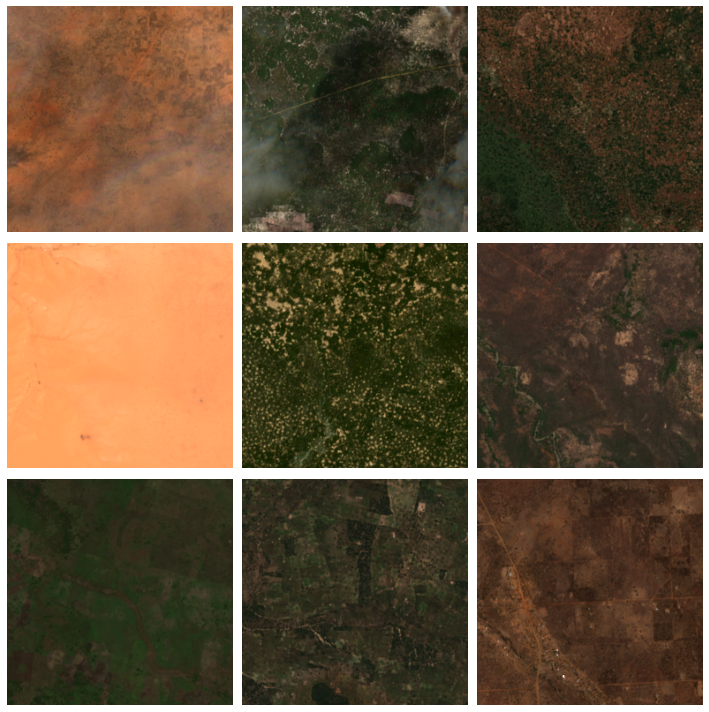

In [10]:
import matplotlib.pyplot as plt

imgs, masks = next(iter(ds.train_dataloader()))
fig = plt.figure(figsize=(10, 10))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
plt.tight_layout()
plt.show()